In [2]:
from pycaret.datasets import get_data
from pycaret.classification import *
from sklearn.model_selection import train_test_split

In [3]:
# load credit dataset
credit_data = get_data("credit")

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [4]:
print(f"There are {credit_data.shape[0]} samples with {credit_data.shape[1]} features per sample.")

There are 24000 samples with 24 features per sample.


In [5]:
# create a train and test split
data_train, data_test = train_test_split(credit_data, test_size=0.1)
print(f"Number of samples in train: {data_train.shape[0]}")
print(f"Number of samples in test: {data_test.shape[0]}")

Number of samples in train: 21600
Number of samples in test: 2400


In [5]:
# call the pycaret setup function to setup the transformation pipeline
classification_setup = setup(data=data_train, 
                             target="default",
                             normalize=True,
                             transformation=True, # make data more gaussian like
                             ignore_low_variance=True, # ignore features with low variance
                             remove_multicollinearity=True, # remove features with inter-correlations higher than 0.9 -> feature that is less correlated with target is removed
                             group_features = [['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], # features with related characteristics
                                              ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']],
                             use_gpu=True # use GPU when available, otherwise CPU                                               
                            )

,Description,Value
0,session_id,816
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(21600, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparing All Models

Let's now compare all models. For this, we make use of the ***compare_models()*** function of pycaret. This function trains all models from the model library and uses stratified 10-fold cross validation to evaluate each of them.

In [6]:
best_3_models = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8199,0.0000,0.3490,0.6763,0.4601,0.3650,0.3940,0.0340
gbc,Gradient Boosting Classifier,0.8190,0.7783,0.3529,0.6691,0.4618,0.3653,0.3925,4.3190
lightgbm,Light Gradient Boosting Machine,0.8190,0.7738,0.3661,0.6606,0.4709,0.3724,0.3961,0.6630
lda,Linear Discriminant Analysis,0.8189,0.7705,0.3703,0.6576,0.4736,0.3744,0.3971,0.1700
svm,SVM - Linear Kernel,0.8188,0.0000,0.3288,0.6866,0.4440,0.3515,0.3859,0.2090
ada,Ada Boost Classifier,0.8184,0.7714,0.3267,0.6831,0.4416,0.3491,0.3832,0.9640
lr,Logistic Regression,0.8183,0.7718,0.3439,0.6697,0.4541,0.3585,0.3873,0.7050
rf,Random Forest Classifier,0.8151,0.7628,0.3577,0.6448,0.4598,0.3591,0.3820,0.8720
et,Extra Trees Classifier,0.8078,0.7502,0.3544,0.6094,0.4477,0.3412,0.3598,1.2030
nb,Naive Bayes,0.8044,0.7544,0.2453,0.6437,0.3525,0.2652,0.3086,0.0190


In [7]:
print(best_3_models)

[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=816, solver='auto',
                tol=0.001), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=816, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='spli

## Optimize Final Model
For this we are making use of the ***create_model()*** function of pycaret. This function trains and evaluates a model using cross validation. 

Let's focus on AUC and continue with the Gradient Boosting classifier.

In [8]:
final_classifier = create_model("gbc", fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8231,0.7668,0.3483,0.6967,0.4645,0.3723,0.4044
1,0.8204,0.7869,0.3393,0.6869,0.4543,0.3612,0.3935
2,0.8247,0.7892,0.3609,0.6957,0.4752,0.3825,0.4122
3,0.8122,0.7724,0.3564,0.6286,0.4549,0.3517,0.3724
4,0.8144,0.7703,0.3594,0.6390,0.4601,0.3585,0.3801
Mean,0.8190,0.7771,0.3529,0.6694,0.4618,0.3652,0.3925
Std,0.0049,0.0091,0.0080,0.0294,0.0077,0.0109,0.0147


Let's now tune this model!

In [9]:
tuned_classfier_AUC = tune_model(final_classifier, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8135,0.7595,0.2342,0.7429,0.3562,0.2802,0.3445
1,0.8128,0.7753,0.2432,0.7232,0.3640,0.2848,0.3433
2,0.8049,0.7741,0.2222,0.6727,0.3341,0.2523,0.3058
3,0.8188,0.7882,0.2462,0.7810,0.3744,0.3006,0.3696
4,0.8115,0.7788,0.2222,0.7400,0.3418,0.2673,0.3338
5,0.8181,0.7979,0.2492,0.7685,0.3764,0.3010,0.3669
6,0.8062,0.7434,0.2132,0.6961,0.3264,0.2489,0.3088
7,0.8241,0.7976,0.2861,0.7661,0.4167,0.3376,0.3946
8,0.8234,0.7818,0.2651,0.7928,0.3973,0.3228,0.3898


In [10]:
tuned_classifier_F1 = tune_model(final_classifier, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8181,0.7669,0.3664,0.6559,0.4701,0.3708,0.3938
1,0.8128,0.7733,0.3453,0.6389,0.4483,0.3475,0.3714
2,0.8181,0.7673,0.3634,0.6576,0.4681,0.3692,0.3929
3,0.8261,0.7871,0.3964,0.6804,0.5009,0.4044,0.4260
4,0.8208,0.7769,0.3844,0.6598,0.4858,0.3862,0.4069
5,0.8221,0.7826,0.3574,0.6839,0.4694,0.3749,0.4035
6,0.7910,0.7454,0.3063,0.5455,0.3923,0.2779,0.2948
7,0.8280,0.7836,0.4217,0.6731,0.5185,0.4205,0.4375
8,0.8300,0.7865,0.4066,0.6923,0.5123,0.4177,0.4394


In [11]:
plot_model(tuned_classifier_F1, plot="parameter")

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,deviance
max_depth,5
max_features,sqrt
max_leaf_nodes,None
min_impurity_decrease,0.02
min_impurity_split,None


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


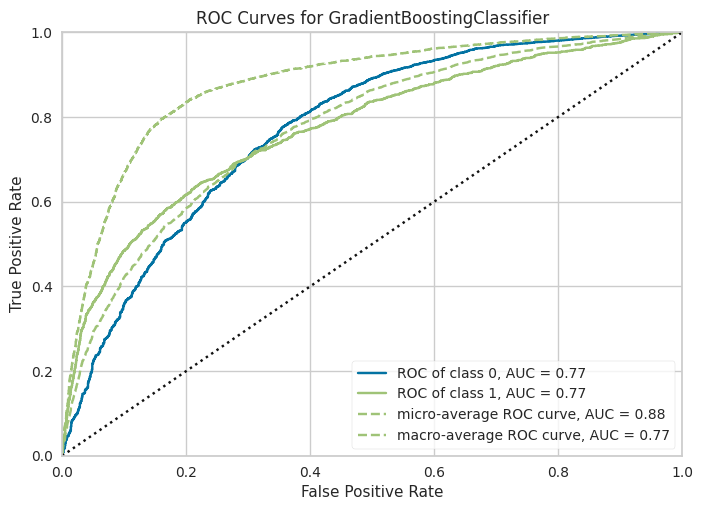

In [13]:
plot_model(tuned_classifier_F1, plot="auc")

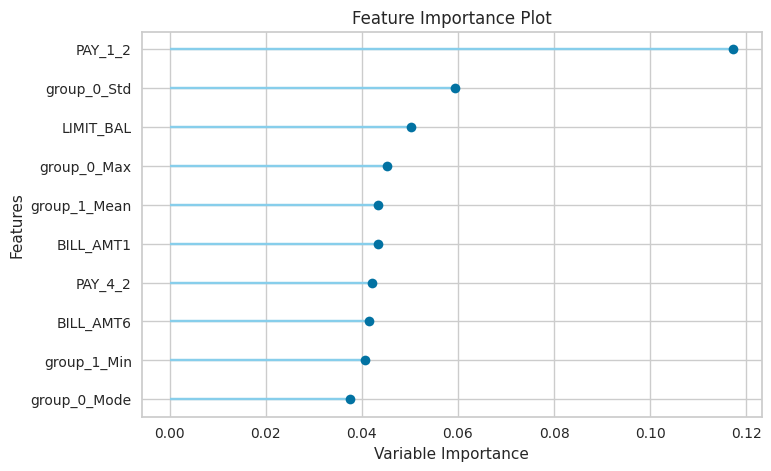

In [14]:
plot_model(tuned_classifier_F1, plot="feature")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


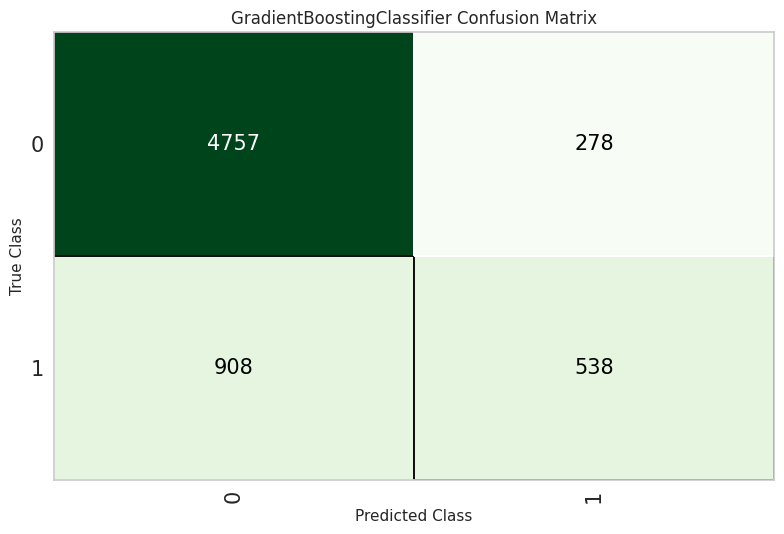

In [15]:
plot_model(tuned_classifier_F1, plot="confusion_matrix")

## Predict on hold-out Test Set
For this we can use the hold-out test set that was created in the ***setup()*** function. This test data was not used for all the cross-validation evaluations.

In [16]:
predict_model(tuned_classifier_F1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8170,0.7734,0.3721,0.6593,0.4757,0.3751,0.3976


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,...,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_7,default,Label,Score
0,0.286317,-0.824754,-1.101971,-0.984450,-1.254643,-1.211453,-1.147840,-1.100222,-1.109184,-1.066784,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7128
1,0.110777,0.462688,-1.096939,-0.572908,-0.947003,1.760793,1.809044,1.693208,1.506700,0.185357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9031
2,0.516186,-0.670989,-0.994062,0.063928,-1.254643,0.661255,2.024341,0.969570,-1.109184,-0.488098,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8923
3,1.000973,0.359934,-1.017096,-0.888144,-0.006089,-0.310491,-0.148740,-0.061113,-0.062674,1.685961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8657
4,1.375688,0.138079,1.243588,-0.533679,2.030266,1.564219,2.053359,2.052603,1.586291,2.098736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6476,-0.648848,1.305909,0.986227,0.210595,0.259986,0.276975,-0.466968,-0.391731,-0.446790,-0.478635,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8354
6477,1.417363,0.462688,0.935124,0.992644,0.673797,0.112742,0.300898,0.394815,0.569353,2.232529,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9610
6478,0.947763,-0.983471,1.502357,1.503163,0.889753,-0.259879,-0.572471,-0.005306,2.207680,2.242903,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8828
6479,0.715698,1.377627,-1.101971,-0.640119,-1.254643,-1.211453,-1.147840,-1.100222,1.324273,-1.066784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5107


## Predict on "New" and Unseen Data
This time we use the data that we initially excluded before the training. This data was even not preprocessed and so on. This data is therefore our simulation of new incoming data.

In [17]:
predict_model(tuned_classifier_F1, data=data_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8088,0.7524,0.3302,0.6331,0.4340,0.3324,0.3579


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Label,Score
1672,180000,2,1,2,27,-1,2,-1,-1,-1,...,150.0,0.0,376.0,0.0,2202.0,0.0,819.0,0,0,0.7366
19000,240000,2,3,2,49,-1,0,0,0,2,...,13540.0,3000.0,3000.0,3000.0,0.0,4000.0,3000.0,0,0,0.8499
3164,220000,2,2,1,35,0,0,0,0,0,...,33933.0,3500.0,6000.0,3000.0,2340.0,5000.0,2000.0,0,0,0.8886
21706,180000,1,2,2,36,0,0,0,0,0,...,133835.0,6600.0,6600.0,6000.0,6000.0,6000.0,5000.0,0,0,0.9560
14242,210000,1,1,2,27,0,0,0,0,0,...,53032.0,8000.0,5000.0,4000.0,3000.0,8000.0,3000.0,0,0,0.9687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6068,30000,1,2,2,49,0,0,0,0,0,...,0.0,1526.0,1696.0,1015.0,0.0,0.0,0.0,0,0,0.8855
21400,80000,1,2,1,27,-1,0,0,0,0,...,43112.0,3181.0,2050.0,1684.0,1564.0,1558.0,2000.0,0,0,0.7063
4116,30000,2,5,2,23,2,2,-1,-1,-1,...,436.0,0.0,16952.0,16104.0,14000.0,486.0,0.0,0,0,0.7254
3725,210000,1,1,2,30,-1,-1,-1,-1,0,...,25112.0,0.0,1000.0,15385.0,5302.0,5112.0,4213.0,0,0,0.9267


## Fix Imbalance
The model that we have trained so far does not really behave well on the class 1. This is because the dataset is imbalanced and has seen more data of class 0 and is therefore better in predicting class 0 than class 1. Let's now fix this by solving the imabalnce issue.

In [6]:
# call the pycaret setup function to setup the transformation pipeline
classification_setup = setup(data=data_train, 
                             target="default",
                             normalize=True,
                             transformation=True, # make data more gaussian like
                             ignore_low_variance=True, # ignore features with low variance
                             remove_multicollinearity=True, # remove features with inter-correlations higher than 0.9 -> feature that is less correlated with target is removed
                             group_features = [['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], # features with related characteristics
                                              ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']],
                             fix_imbalance=True,
                             use_gpu=True # use GPU when available, otherwise CPU                                               
                            )

,Description,Value
0,session_id,6069
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(21600, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [7]:
final_classifier = create_model("gbc", fold=5)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8221,0.7681,0.4977,0.6187,0.5517,0.4423,0.4464
1,0.8112,0.7736,0.4458,0.5932,0.5090,0.3950,0.4012
2,0.8108,0.7746,0.4910,0.5821,0.5327,0.4152,0.4175
3,0.7976,0.7633,0.4458,0.5481,0.4917,0.3670,0.3701
4,0.8098,0.7652,0.4849,0.5802,0.5283,0.4104,0.4130
Mean,0.8103,0.7690,0.4730,0.5845,0.5227,0.4060,0.4096
Std,0.0078,0.0045,0.0226,0.0228,0.0206,0.0247,0.0247


In [8]:
tuned_classifier_F1 = tune_model(final_classifier, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8009,0.7932,0.6126,0.5426,0.5755,0.4461,0.4475
1,0.7632,0.7438,0.5843,0.4686,0.5201,0.3655,0.3694
2,0.7731,0.7771,0.5904,0.4864,0.5333,0.3853,0.3885
3,0.7765,0.7866,0.6024,0.4926,0.5420,0.3961,0.3996
4,0.7679,0.7885,0.6325,0.4784,0.5447,0.3930,0.3999
5,0.7619,0.7588,0.5873,0.4665,0.5200,0.3644,0.3687
6,0.7659,0.7604,0.5753,0.4728,0.5190,0.3663,0.3693
7,0.7731,0.7609,0.5723,0.4859,0.5256,0.3778,0.3800
8,0.7540,0.7619,0.6024,0.4545,0.5181,0.3573,0.3636


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


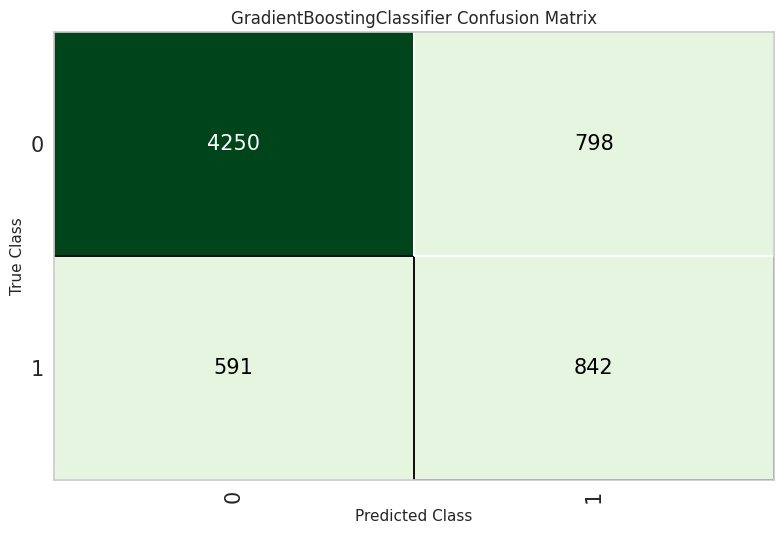

In [9]:
plot_model(tuned_classifier_F1, plot="confusion_matrix")


In [10]:
# predict on unseen data
predict_model(tuned_classifier_F1, data=data_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7700,0.7704,0.5942,0.5000,0.5430,0.3909,0.3935


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Label,Score
5946,430000,1,1,2,28,0,0,0,0,0,...,339050.0,40000.0,30000.0,35000.0,30000.0,20019.0,40000.0,0,0,0.5029
3800,160000,1,2,2,28,1,2,2,2,2,...,154704.0,6000.0,14.0,12000.0,6000.0,0.0,11318.0,0,1,0.5029
4972,430000,2,2,2,27,-2,-2,-2,-2,-2,...,15562.0,1764.0,4120.0,535.0,20990.0,2506.0,500.0,1,0,0.5018
609,50000,1,2,2,26,0,0,0,0,0,...,20041.0,2100.0,1227.0,383.0,2000.0,20000.0,649.0,1,0,0.5013
15926,310000,2,2,1,46,0,0,0,0,0,...,51337.0,3000.0,3000.0,2000.0,3000.0,3000.0,1000.0,0,0,0.5025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9539,30000,2,1,2,26,-1,-1,-1,-1,0,...,15222.0,125.0,125.0,4671.0,25000.0,3000.0,2256.0,0,0,0.5015
19347,310000,1,1,2,32,0,0,0,0,0,...,150442.0,8500.0,9100.0,5200.0,7300.0,7000.0,3939.0,0,0,0.5028
19342,500000,1,2,2,32,0,0,0,0,0,...,106476.0,10558.0,7410.0,3068.0,94.0,106476.0,152.0,0,0,0.5019
6453,50000,1,1,2,29,-1,2,2,2,2,...,42852.0,0.0,5160.0,1753.0,0.0,1508.0,5000.0,1,1,0.5025
